In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import DataModelQlty, AIQlty, utils, Event, Simulation, root_files
np.set_printoptions(precision=2, linewidth=115, suppress=True)

%matplotlib inline

In [6]:
# model name
model_name = 'model-lsr-quality-old'

# source model name to load the network weights
source_model = 'model-lsr-old'

shuffle_clusters = False

# load the training data
data = DataModelQlty('data-qlty-top-8-old.npz', batch_size = 128, 
                     validation_percent = .1, test_percent = .2)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AIQlty(data, model_name)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()
    
# balance the training data since there are too many background events
ai.data.balance_training = True

# define the priority of selection
ai.data.weight_non_compton = .1

In [7]:
# define the learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 20:
        return .001
    elif epoch < 40:
        return .0003
    elif epoch < 60:
        return .0001
    elif epoch < 80:
        return .00001
    else:
        return .000003

# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.000, limbs_l2=.000)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [8]:
#LOADING THE MODEL
ai.load(source_model, optimizer=False)
ai.extend_model(quality_layers=[64, 32, 32], plot_summary=False)
ai.load(model_name, optimizer=False)
ai.compile_model()

In [5]:
# TRAINING THE MODEL
# load the weights of the source model
ai.load(source_model, optimizer=False)
ai.compile_model()

In [6]:
# freeze all network components
for layer in ai.model.layers:
    layer.trainable = False
    
# extend the model with the quality part
ai.extend_model(quality_layers=[64, 32, 32], limbs_l2=.00003)

# # eliminate the components weight not intended for training
ai.weight_type =      0
ai.weight_e_cluster = 0
ai.weight_p_cluster = 0
ai.weight_pos_x =     0
ai.weight_pos_y =     0
ai.weight_pos_z =     0
ai.weight_energy =    0
ai.weight_qlty =      1

# print the trainable layers
print('\ntrainable layers:')
for layer in ai.model.layers:
    if layer.trainable:
        print('{:17s}{}'.format(layer.name, layer.trainable))

# compile the model for training
ai.compile_model(learning_rate=.001)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [7]:
%%time
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

# start the training of the network
ai.train(epochs=100, shuffle_clusters=shuffle_clusters, 
         verbose=0, callbacks = l_callbacks)

CPU times: user 5h 52min 21s, sys: 3min 19s, total: 5h 55min 40s
Wall time: 5h 58min 15s


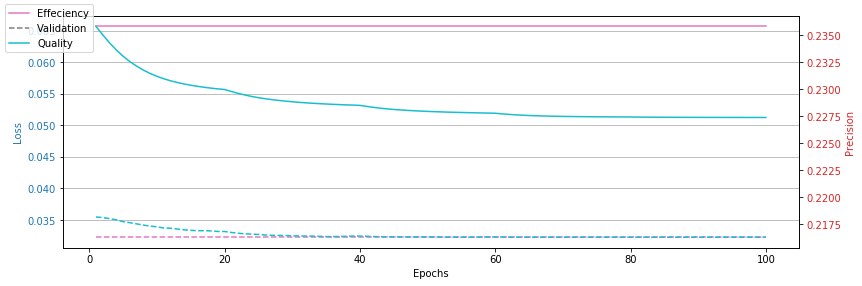

In [8]:
ai.plot_training_loss(mode='loss-quality', summed_loss=False)

In [9]:
ai.evaluate(quality_filter=[.65,.65,.65,.65])

AI model
  Loss:        0.03368
    -Type:         0.33529 *  0.00 = 0.00000
    -Pos X:        0.06182 *  0.00 = 0.00000
    -Pos Y:        1.73444 *  0.00 = 0.00000
    -Pos Z:        0.04469 *  0.00 = 0.00000
    -Energy:       1.53363 *  0.00 = 0.00000
    -Cls e:        0.04658 *  0.00 = 0.00000
    -Cls p:        0.09138 *  0.00 = 0.00000
    -Quality:      0.03198 *  1.00 = 0.03198
  Accuracy:     0.85689
    -Precision:    0.67767
    -Recall:       0.35837
    -Cls e rate:   0.95138
    -Cls p rate:   0.88517
  Efficiency:   0.14061
  Purity:       0.26590
  Euc mean:     6.93235
  Euc std:     18.25172
  Energy mean:  0.25387
  Energy std:   0.63080

Reco
  Accuracy:     0.64428
    -TP rate:      0.75267
  Efficiency:   0.12909
  Purity:       0.07334
  Euc mean:    21.09294
  Euc std:     49.40878
  Energy mean:  0.54133
  Energy std:   1.10471


In [5]:
ai.evaluate(quality_filter=[.75,.75,.7,.7])

AI model
  Loss:        5.11936
    -Type:         0.33529 *  2.00 = 0.67059
    -Pos X:        0.06182 *  2.50 = 0.15455
    -Pos Y:        1.73444 *  1.00 = 1.73444
    -Pos Z:        0.04469 *  2.00 = 0.08938
    -Energy:       1.53363 *  1.50 = 2.30044
    -Cls e:        0.04658 *  1.00 = 0.04658
    -Cls p:        0.09138 *  1.00 = 0.09138
    -Quality:      0.03198 *  1.00 = 0.03198
  Accuracy:     0.85689
    -Precision:    0.65718
    -Recall:       0.19782
    -Cls e rate:   0.95138
    -Cls p rate:   0.88517
  Efficiency:   0.09361
  Purity:       0.31097
  Euc mean:     5.84566
  Euc std:     14.09324
  Energy mean:  0.24250
  Energy std:   0.60352

Reco
  Accuracy:     0.64428
    -TP rate:      0.75267
  Efficiency:   0.12909
  Purity:       0.07334
  Euc mean:    21.09294
  Euc std:     49.40878
  Energy mean:  0.54133
  Energy std:   1.10471


In [10]:
# save the trained model
ai.save(file_name=model_name)

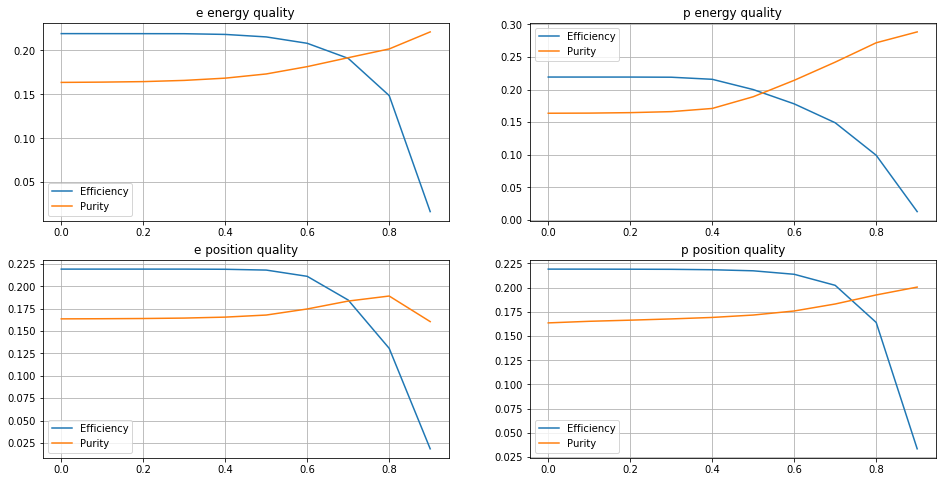

CPU times: user 3min 16s, sys: 5.45 s, total: 3min 22s
Wall time: 3min 22s


In [11]:
%%time
def plot_cross_evaluation(pos, title):
    l_quality = [None, .1, .2, .3, .4, .5, .6, .7, .8, .9]
    l_filter = [None, None, None, None]
    l_eff = []
    l_pur = []
    for i in l_quality:
        l_filter[pos] = i
        eff, pur = ai.calc_eff_pur(quality_filter=l_filter)
        l_eff.append(eff)
        l_pur.append(pur)

    plt.title(title)
    plt.plot(np.arange(0,1,.1), l_eff, label='Efficiency')
    plt.plot(np.arange(0,1,.1), l_pur, label='Purity')
    plt.grid()
    plt.legend()
    
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plot_cross_evaluation(0, 'e energy quality')
plt.subplot(2,2,2)
plot_cross_evaluation(1, 'p energy quality')
plt.subplot(2,2,3)
plot_cross_evaluation(2, 'e position quality')
plt.subplot(2,2,4)
plot_cross_evaluation(3, 'p position quality')
plt.show()